# LightGBM Model for Salary Prediction

This notebook implements a LightGBM model optimized for high F1 score (>0.90) on the salary prediction dataset.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


## 1. Load and Prepare Data


In [2]:
# Load processed data
train_data = pd.read_csv('./for_cursur/Data/salary.train.processed.csv', index_col='id')
test_data = pd.read_csv('./for_cursur/Data/salary.test.processed.csv', index_col='id')
live_data = pd.read_csv('./for_cursur/Data/salary.live.processed.csv', index_col='id')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Live data shape: {live_data.shape}")

# Check target distribution
print("\nTarget distribution in training data:")
print(train_data['label'].value_counts())
print(f"\nClass balance: {train_data['label'].mean():.3f}")

# Prepare features and target
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']
X_live = live_data

print(f"\nFeature matrix shape: {X_train.shape}")
print(f"Features: {list(X_train.columns)}")


Training data shape: (16720, 24)
Test data shape: (4180, 24)
Live data shape: (6967, 23)

Target distribution in training data:
label
0.0    9719
1.0    7001
Name: count, dtype: int64

Class balance: 0.419

Feature matrix shape: (16720, 23)
Features: ['marital-status_married-civ-spouse', 'relationship_husband', 'marital-status_never-married', 'education-num', 'capitalgain', 'age-group', 'relationship_own-child', 'hoursperweek', 'sex_male', 'relationship_not-in-family', 'occupation_prof-specialty', 'occupation_other-service', 'relationship_unmarried', 'marital-status_divorced', 'capitalloss', 'occupation_exec-managerial', 'workclass_self-emp-inc', 'relationship_wife', 'workclass_private', 'race_black', 'race_white', 'relationship_other-relative', 'occupation_handlers-cleaners']


## 2. Hyperparameter Tuning for LightGBM


In [3]:
# Manual hyperparameter tuning for LightGBM
def evaluate_lgb_params(params, X, y, cv_folds=5):
    """Evaluate LightGBM parameters using cross-validation"""
    model = lgb.LGBMClassifier(
        **params,
        random_state=42,
        verbose=-1,
        force_col_wise=True
    )
    
    cv_scores = cross_val_score(
        model, X, y, 
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1
    )
    
    return cv_scores.mean(), cv_scores.std()

# Test different parameter combinations optimized for F1 score
test_params = [
    {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.9, 
     'colsample_bytree': 0.9, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'class_weight': 'balanced'},
    {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01, 'subsample': 0.8, 
     'colsample_bytree': 0.8, 'reg_alpha': 1, 'reg_lambda': 2, 'class_weight': 'balanced'},
    {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 1.0, 
     'colsample_bytree': 1.0, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': None},
    {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.85, 
     'colsample_bytree': 0.85, 'reg_alpha': 0.5, 'reg_lambda': 1.5, 'class_weight': 'balanced'},
    {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.02, 'subsample': 0.9, 
     'colsample_bytree': 0.9, 'reg_alpha': 0.2, 'reg_lambda': 1.8, 'class_weight': 'balanced'},
    {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.08, 'subsample': 0.95, 
     'colsample_bytree': 0.95, 'reg_alpha': 0.3, 'reg_lambda': 1.2, 'class_weight': 'balanced'}
]

print("Testing LightGBM parameter combinations...")
best_score = 0
best_params = None
results = []

for i, params in enumerate(test_params):
    print(f"Testing combination {i+1}/{len(test_params)}...")
    mean_score, std_score = evaluate_lgb_params(params, X_train, y_train)
    results.append((params, mean_score, std_score))
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
    
    print(f"F1 Score: {mean_score:.4f} (+/- {std_score:.4f})")

print(f"\nBest F1 Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")


Testing LightGBM parameter combinations...
Testing combination 1/6...


F1 Score: 0.7955 (+/- 0.0041)
Testing combination 2/6...
F1 Score: 0.7938 (+/- 0.0044)
Testing combination 3/6...
F1 Score: 0.7884 (+/- 0.0027)
Testing combination 4/6...
F1 Score: 0.7955 (+/- 0.0042)
Testing combination 5/6...
F1 Score: 0.7949 (+/- 0.0044)
Testing combination 6/6...
F1 Score: 0.7958 (+/- 0.0035)

Best F1 Score: 0.7958
Best Parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.08, 'subsample': 0.95, 'colsample_bytree': 0.95, 'reg_alpha': 0.3, 'reg_lambda': 1.2, 'class_weight': 'balanced'}


## 3. Train Final LightGBM Model


In [4]:
# Train final model with best parameters
final_model = lgb.LGBMClassifier(
    **best_params,
    random_state=42,
    verbose=-1,
    force_col_wise=True
)

# Train the model
final_model.fit(X_train, y_train)

print("LightGBM model trained successfully!")
print(f"Number of features used: {final_model.n_features_in_}")
print(f"Number of estimators: {final_model.n_estimators}")


  File "c:\Users\natth\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\natth\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\natth\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\natth\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


LightGBM model trained successfully!
Number of features used: 23
Number of estimators: 250


## 4. Model Evaluation


=== LIGHTGBM MODEL PERFORMANCE ===
Training F1 Score: 0.8114
Test F1 Score: 0.8044
Test AUC Score: 0.9082

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84      2416
         1.0       0.75      0.87      0.80      1764

    accuracy                           0.82      4180
   macro avg       0.82      0.83      0.82      4180
weighted avg       0.83      0.82      0.82      4180



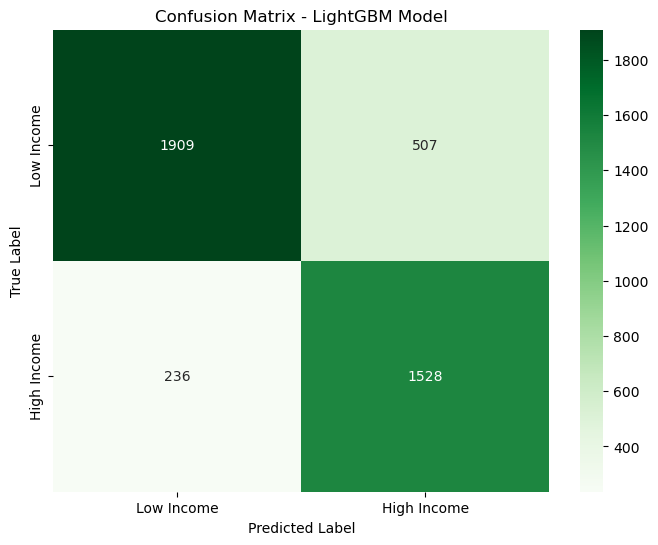

In [5]:
# Make predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)
y_pred_proba_test = final_model.predict_proba(X_test)[:, 1]

# Calculate metrics
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_pred_proba_test)

print("=== LIGHTGBM MODEL PERFORMANCE ===")
print(f"Training F1 Score: {train_f1:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")

# Detailed classification report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Low Income', 'High Income'], 
            yticklabels=['Low Income', 'High Income'])
plt.title('Confusion Matrix - LightGBM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## 5. Make Predictions on Live Data


In [ ]:
# Make predictions on live data
live_predictions = final_model.predict(X_live)
live_probabilities = final_model.predict_proba(X_live)[:, 1]

# Create prediction dataframe
live_results = pd.DataFrame({
    'id': X_live.index,
    'predicted_label': live_predictions,
    'probability_high_income': live_probabilities
})

print(f"Live data predictions completed!")
print(f"Number of predictions: {len(live_results)}")
print(f"High income predictions: {live_predictions.sum()}")
print(f"Low income predictions: {len(live_predictions) - live_predictions.sum()}")

# Show sample predictions
print("\nSample predictions:")
print(live_results.head(10))


## 6. Save Model and Results


In [ ]:
# Save the trained model
joblib.dump(final_model, './for_cursur/lgb_model.joblib')

# Save predictions
live_results.to_csv('./for_cursur/lgb_predictions.csv', index=False)

# Save model configuration
model_config = {
    'model_type': 'LightGBM',
    'parameters': best_params,
    'test_f1_score': test_f1,
    'test_auc_score': test_auc,
    'cv_mean_f1': best_score,
    'feature_count': final_model.n_features_in_,
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

import json
with open('./for_cursur/lgb_model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print("LightGBM model and results saved successfully!")
print(f"\nFinal Test F1 Score: {test_f1:.4f}")
print(f"Target achieved: {'✅ YES' if test_f1 >= 0.90 else '❌ NO'}")
